In [ ]:
import os
import glob
import re
import numpy as np
import pandas as pd
import torch
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import random
import time
from babel.dates import format_date, format_datetime, format_time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    BertModel,
    AutoModel,
    AdamW,
    get_linear_schedule_with_warmup,
    BertTokenizer,
    BertForSequenceClassification,
)
from sklearn.metrics import classification_report
from datasets import Dataset, DatasetDict

from tabulate import tabulate
import shutil
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
# Reading the dataset
train_df = pd.read_csv('./data/train_en.tsv', delimiter='\t')
val_df = pd.read_csv('./data/dev_en.tsv', delimiter='\t')
test_df = pd.read_csv('./data/test_en_gold.tsv', delimiter='\t')

train_df['label'] = train_df['label'].replace({'SUBJ': 0, 'OBJ': 1})
val_df['label'] = val_df['label'].replace({'SUBJ': 0, 'OBJ': 1})
test_df['label'] = test_df['label'].replace({'SUBJ': 0, 'OBJ': 1})

In [5]:
df = train_df
train_df

,sentence_id,sentence,label,solved_conflict
0,b9e1635a-72aa-467f-86d6-f56ef09f62c3,Gone are the days when they led the world in r...,0,True
1,f99b5143-70d2-494a-a2f5-c68f10d09d0a,The trend is expected to reverse as soon as ne...,1,False
2,4076639c-aa56-4202-ae0f-9d9217f8da68,But there is the specious point again.,1,False
3,b057c366-698e-419d-a284-9b16d835c64e,He added he wouldn’t be surprised to see a new...,1,False
4,a5a9645e-7850-41ba-90a2-5def725cd5b8,"Not less government, you see; the same amount ...",0,False
...,...,...,...,...
825,9a0f5eec-cc36-49b8-88eb-20ad2c056eaa,Local governments and their financing vehicles...,0,False
826,73545884-adf8-480c-a8b5-e65128ba8e91,That fact alone underscores the biggest proble...,0,False
827,a8825286-21a4-46c9-9410-c0e7e183d708,Presumably it had in mind those Russian offici...,0,False
828,c984fc97-2604-4690-a2c0-d748703663af,"From bad taxation, reckless borrowing and reck...",0,False


In [6]:
train_df.describe()

,label
count,830.000000
mean,0.640964
std,0.480007
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentence_id      830 non-null    object
 1   sentence         830 non-null    object
 2   label            830 non-null    int64 
 3   solved_conflict  830 non-null    bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 20.4+ KB


# Get to know the data

<Axes: >

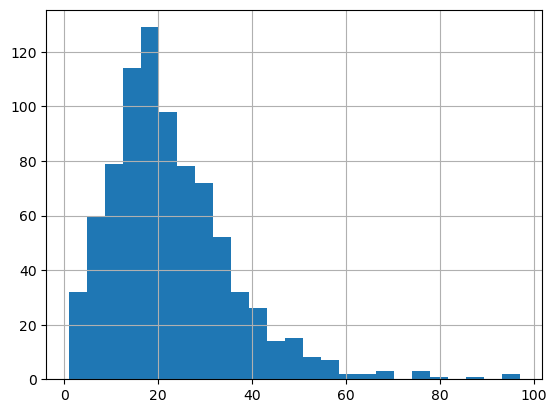

In [8]:
seq_len_premise = [len(i.split()) for i in train_df['sentence']]

pd.Series(seq_len_premise).hist(bins = 25)

## Wordclouds

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


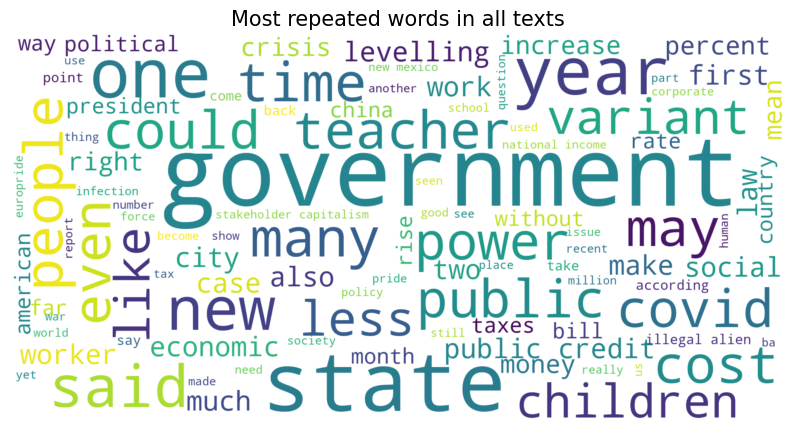

In [9]:
# Wordcloud of text

nltk.download('stopwords')

# Get stopwords
# Define nltk stopwords in english
stop_words = stopwords.words('english')

stop_words.extend(['u', 'wa', 'ha', 'would', 'com'])

# Get a string of all the texts available
data_text = ",".join(txt.lower() for txt in train_df.sentence)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all texts',fontsize=15)
plt.show()

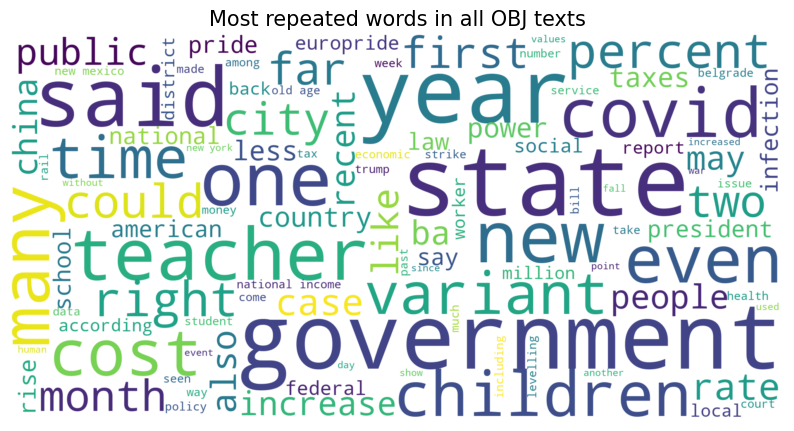

In [10]:
# Get a string of the true texts only
data_text_true = ",".join(txt.lower() for txt in train_df.sentence[train_df.label == 1])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text_true)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all OBJ texts',fontsize=15)
plt.show()

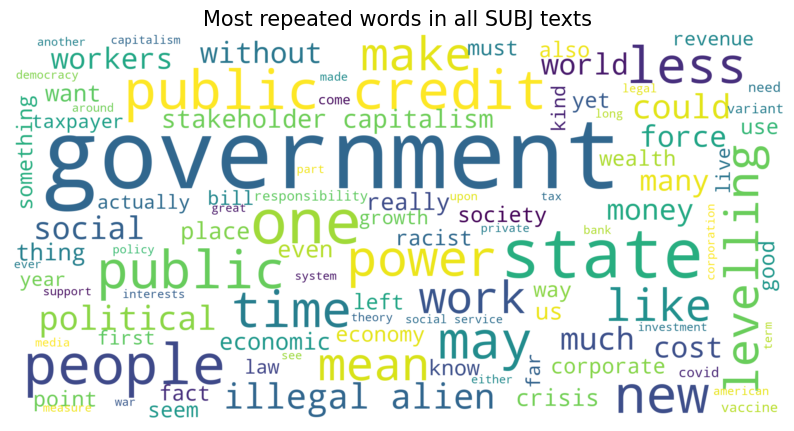

In [11]:
# Get a string of the fake news text only
data_text_fake = ",".join(txt.lower() for txt in train_df.sentence[train_df.label==0])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(data_text_fake)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all SUBJ texts',fontsize=15)
plt.show()

## Term frequencies

In [ ]:
# Check the word frequency in texts

nltk.download('wordnet')

# lemmatize text column by using a lemmatize function
def lemmatize_text(text):
   return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text.lower())]


# Initialize the Lemmatizer and Whitespace Tokenizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Lemmatize words
df['text_lemmatized'] = df.sentence.apply(lemmatize_text)
df['text_lemmatized'] = df['text_lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])

# use explode to expand the lists into separate rows
wf_text = df.text_lemmatized.explode().to_frame().reset_index(drop=True)

# plot
sns.countplot(x='text_lemmatized', data=wf_text, order=wf_text.text_lemmatized.value_counts().iloc[:10].index)
plt.xlabel('Most common used words in all texts')
plt.ylabel('Frequency [%]')
plt.xticks(rotation=70)

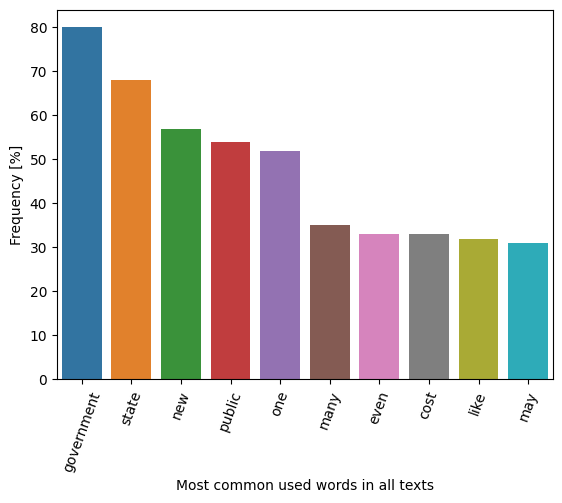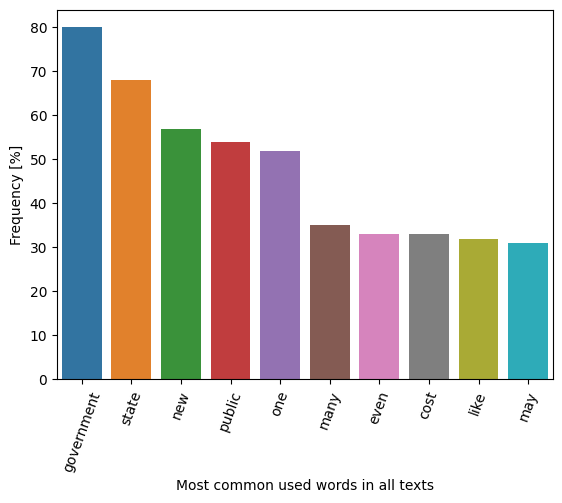
# Cleaning the data

In [12]:
#  Preprocess train dataset
# remove special characters from text column

train_df.sentence = train_df.sentence.str.replace('[#,@,&]', '', regex = True)
val_df.sentence = val_df.sentence.str.replace('[#,@,&]', '', regex = True)
test_df.sentence = test_df.sentence.str.replace('[#,@,&]', '', regex = True)

# Remove digits
train_df.sentence = train_df.sentence.str.replace('\d*','', regex = True)
val_df.sentence = val_df.sentence.str.replace('\d*','', regex = True)
test_df.sentence = test_df.sentence.str.replace('\d*','', regex = True)

#Remove www
train_df.sentence = train_df.sentence.str.replace('w{3}','', regex = True)
val_df.sentence = val_df.sentence.str.replace('w{3}','', regex = True)
test_df.sentence = test_df.sentence.str.replace('w{3}','', regex = True)

# remove urls
train_df.sentence = train_df.sentence.str.replace("http\S+", "", regex = True)
val_df.sentence = val_df.sentence.str.replace("http\S+", "", regex = True)
test_df.sentence = test_df.sentence.str.replace("http\S+", "", regex = True)

# remove multiple spaces with single space
train_df.sentence = train_df.sentence.str.replace('\s+', ' ', regex = True)
val_df.sentence = val_df.sentence.str.replace('\s+', ' ', regex = True)
test_df.sentence = test_df.sentence.str.replace('\s+', ' ', regex = True)

#remove all single characters
train_df.sentence = train_df.sentence.str.replace(r'\s+[a-zA-Z]\s+', '', regex = True)
val_df.sentence = val_df.sentence.str.replace(r'\s+[a-zA-Z]\s+', '', regex = True)
test_df.sentence = test_df.sentence.str.replace(r'\s+[a-zA-Z]\s+', '', regex = True)

# Remove english stopwords
train_df['sentence'] = train_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
val_df['sentence'] = val_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['sentence'] = test_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [13]:
train_df['label'] = train_df['label'].replace({'SUBJ': 0, 'OBJ': 1})
val_df['label'] = val_df['label'].replace({'SUBJ': 0, 'OBJ': 1})
test_df['label'] = test_df['label'].replace({'SUBJ': 0, 'OBJ': 1})

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
validation_dataset = Dataset.from_pandas(val_df)
testing_dataset = Dataset.from_pandas(test_df)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': testing_dataset,
})

print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict'],
        num_rows: 830
    })
    validation: Dataset({
        features: ['sentence_id', 'sentence', 'label', 'solved_conflict'],
        num_rows: 219
    })
    test: Dataset({
        features: ['sentence_id', 'sentence', 'label'],
        num_rows: 243
    })
})


In [14]:
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

In [15]:
def tokenize_function(examples):

    """ This function tokenizes the text in the examples dictionary.
        We pass it to the map function of the dataset so that we can batch the tokenization for efficiency by
        tokenizing batches in parallel.
    """
    return roberta_tokenizer(examples["sentence"], padding="max_length", truncation=True)

In [16]:
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize numerical features in the training set
train_features = scaler.fit_transform(tokenized_datasets["train"]["input_ids"])

# Apply the same transformation to the validation and test sets
validation_features = scaler.transform(tokenized_datasets["validation"]["input_ids"])
test_features = scaler.transform(tokenized_datasets["test"]["input_ids"])


In [18]:
train_vectors, y_train = train_features, train_df['label']
test_vectors, y_test = test_features, test_df['label']
val_vectors, y_val = validation_features, val_df['label']

## Baseline model MLPClasifier
First we will use grid search for hyperparameter tuning

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

In [20]:
# Tokenization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_df['sentence'])
val_tfidf = tfidf_vectorizer.transform(val_df['sentence'])
test_tfidf = tfidf_vectorizer.transform(test_df['sentence'])

# Tokenization using Word2Vec
train_tokens = [sentence.split() for sentence in train_df['sentence']]
val_tokens = [sentence.split() for sentence in val_df['sentence']]
test_tokens = [sentence.split() for sentence in test_df['sentence']]

word2vec_model = Word2Vec(train_tokens, window=5, min_count=1)

def get_word_embedding(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        return np.zeros(100)  # Placeholder vector for missing tokens

train_word2vec = [np.mean([get_word_embedding(word) for word in tokens], axis=0) for tokens in train_tokens]
val_word2vec = [np.mean([get_word_embedding(word) for word in tokens], axis=0) for tokens in val_tokens]
test_word2vec = [np.mean([get_word_embedding(word) for word in tokens], axis=0) for tokens in test_tokens]


In [21]:
len(train_word2vec)

830

In [22]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 25, 10)],
    'activation': [ 'logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01],
    'solver' : ['sgd', 'adam']
}

mlp = MLPClassifier(random_state=101)


mlp_grid = ParameterGrid(param_grid)



data = []
head = ['hidden_layer_sizes', 'activation', 'alpha', 'score in validation set']


for param in mlp_grid:
    mlp_model = MLPClassifier(max_iter = 5000, random_state=42, **param)
    mlp_model.fit(train_tfidf, train_df['label'])
    
    predictions = mlp_model.predict(val_tfidf)
    predictions_series = pd.Series(predictions).replace({'SUBJ': 0, 'OBJ': 1})
    
    score = f1_score(val_df['label'], predictions_series)
    list_entry = [param['hidden_layer_sizes'], param['activation'], param['alpha'], param['solver'], score]
    data.insert(0, list_entry)

CPU times: user 5min 43s, sys: 2min 19s, total: 8min 3s
Wall time: 4min 15s


In [24]:
print(tabulate(data, headers=head, tablefmt="pipe"))
max_accuracy = max(entry[4] for entry in data)
best_model = next(item for item in data if item[4] == max_accuracy)
print("The highest Accuracy %f is the model model with hidden_layer_sizes = %s, activation = %s, alpha = %f, solver = %s"%
      (best_model[4], best_model[0], best_model[1], best_model[2], best_model[3]))

|              | hidden_layer_sizes   |   activation | alpha   |   score in validation set |
|:-------------|:---------------------|-------------:|:--------|--------------------------:|
| (50, 25, 10) | relu                 |       0.01   | adam    |                  0.611111 |
| (50, 25, 10) | relu                 |       0.01   | sgd     |                  0.652308 |
| (50, 50)     | relu                 |       0.01   | adam    |                  0.607004 |
| (50, 50)     | relu                 |       0.01   | sgd     |                  0.652308 |
| (100,)       | relu                 |       0.01   | adam    |                  0.603922 |
| (100,)       | relu                 |       0.01   | sgd     |                  0.652308 |
| (50, 25, 10) | relu                 |       0.001  | adam    |                  0.577075 |
| (50, 25, 10) | relu                 |       0.001  | sgd     |                  0.652308 |
| (50, 50)     | relu                 |       0.001  | adam    |      

In [25]:

best_mlp_model = MLPClassifier( hidden_layer_sizes=best_model[0], activation=best_model[1], alpha=best_model[2], solver ='sgd', random_state=0)
best_mlp_model.fit(train_tfidf, train_df['label'])
y_pred = best_mlp_model.predict(test_tfidf)
mlp_accuracy = best_mlp_model.score(test_tfidf, test_df["label"])
mlp_f_score = precision_recall_fscore_support(test_df["label"], y_pred, average='macro')[2]
print("The MLP model with hidden_layer_sizes = %s, activation = %s, alpha = %f has %s accuracy."
      % (best_model[0], best_model[1], best_model[2], mlp_accuracy))
mlp_report = classification_report(test_df["label"], y_pred, digits=5)
print(mlp_report)


The MLP model with hidden_layer_sizes = (50, 25, 10), activation = relu, alpha = 0.010000 has 0.4773662551440329 accuracy.
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       127
           1    0.47737   1.00000   0.64624       116

    accuracy                        0.47737       243
   macro avg    0.23868   0.50000   0.32312       243
weighted avg    0.22788   0.47737   0.30849       243



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

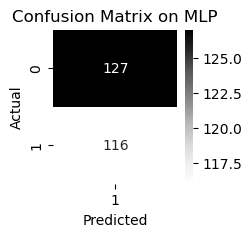

In [26]:


con_matrix = pd.crosstab(pd.Series(pd.DataFrame(test_df["label"]).values.flatten(), name='Actual'), pd.Series(pd.DataFrame(y_pred).values.flatten(), name='Predicted'))
plt.figure(figsize=(2, 2))
plt.title("Confusion Matrix on MLP")
sns.heatmap(con_matrix, cmap="Greys", annot=True, fmt='g')
plt.show()


# SVM

In [43]:
%%time


head = ['C','kernel','score in validation set']

data =[]

svm_param_grid = {'C': [1, 10, 100], 'kernel': ['sigmoid', 'linear', 'poly', 'rbf']}

svm_grid = ParameterGrid(svm_param_grid)

i = 0
for param in svm_grid:
    svm_model = SVC(**param)  
    svm_model.fit(train_tfidf, train_df['label'])
    
    predictions = svm_model.predict(val_tfidf)
    predictions_series = pd.Series(predictions).replace({'SUBJ': 0, 'OBJ': 1})
    
    score = f1_score(val_df["label"], predictions_series)
        
    list_entry = [param['C'],  param['kernel'],score]
    data.insert(0,list_entry)
    
print(tabulate(data, headers=head, tablefmt="pipe"))
max_accuracy = max(entry[2] for entry in data)
for item in data:
    if item[2] == max_accuracy:
        best_model = item
print("The highest Accuracy %f is the model model with C = %d and used %s kernal" %
                (best_model[2],best_model[0],best_model[1]))

|   C | kernel   |   score in validation set |
|----:|:---------|--------------------------:|
| 100 | rbf      |                  0.627986 |
| 100 | poly     |                  0.652308 |
| 100 | linear   |                  0.623482 |
| 100 | sigmoid  |                  0.57377  |
|  10 | rbf      |                  0.627986 |
|  10 | poly     |                  0.652308 |
|  10 | linear   |                  0.623482 |
|  10 | sigmoid  |                  0.567686 |
|   1 | rbf      |                  0.656347 |
|   1 | poly     |                  0.652308 |
|   1 | linear   |                  0.617544 |
|   1 | sigmoid  |                  0.616438 |
The highest Accuracy 0.656347 is the model model with C = 1 and used rbf kernal
CPU times: user 1.26 s, sys: 2.42 ms, total: 1.26 s
Wall time: 1.27 s


In [44]:
svm_model = SVC(C = 1, kernel='rbf')
svm_model.fit(train_tfidf, train_df['label'])
svm_accuracy=svm_model.score(test_tfidf, test_df["label"])
predictions = svm_model.predict(test_tfidf)
svm_f_score = precision_recall_fscore_support(test_df["label"],predictions, average='macro')[2]
print("The SVM model with C = %d and used %s as kernel has %s accuracy with this classification report"
      % (1,"Linear basis function", svm_accuracy))
svm_report = classification_report(test_df["label"],predictions,digits = 5)
print(svm_report)

The SVM model with C = 1 and used Linear basis function as kernel has 0.49382716049382713 accuracy with this classification report
              precision    recall  f1-score   support

           0    0.83333   0.03937   0.07519       127
           1    0.48523   0.99138   0.65156       116

    accuracy                        0.49383       243
   macro avg    0.65928   0.51537   0.36337       243
weighted avg    0.66716   0.49383   0.35033       243



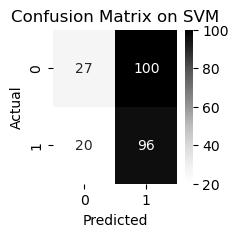

In [53]:
con_matrix = pd.crosstab(pd.Series(pd.DataFrame(y_test).values.flatten(), name='Actual'),
                         pd.Series(pd.DataFrame(predictions).values.flatten(), name='Predicted'))
plt.figure(figsize=(2, 2))
plt.title("Confusion Matrix on SVM")
sns.heatmap(con_matrix, cmap="Greys", annot=True, fmt='g')
plt.show()

# Random Forrest

In [54]:

head = ['n_estimators','criterion','max_depth','score in validation set']
data =[]
rf_param_grid = {'n_estimators': [50, 100, 150], 'criterion': ['entropy', 'gini'],
                'max_depth': [50, 100, 150],
                'max_features': ["sqrt", "log2"]}
rf_grid = ParameterGrid(rf_param_grid)
for param in rf_grid:
    rf_model = RandomForestClassifier(**param)  
    rf_model.fit(train_vectors, y_train)
    
    predictions = rf_model.predict(scaled_val_vectors)
    predictions_series = pd.Series(predictions).replace({'SUBJ': 0, 'OBJ': 1})
    
    score = f1_score(y_val_series, predictions_series)
    
    list_entry = [param['n_estimators'],  param['criterion'], param['max_depth'], param['max_features'],score]

    data.insert(0,list_entry)
print(tabulate(data, headers=head, tablefmt="pipe"))
max_accuracy = max(entry[4] for entry in data)
for item in data:
    if item[4] == max_accuracy:
        best_model = item
print("The highest Accuracy %f is the model model with n_estimators = %d and used %s criterion with max_depth = %s and max_features splitter %s"
      % (best_model[4],best_model[0],best_model[1], best_model[2], best_model[3]))

|     | n_estimators   |   criterion | max_depth   |   score in validation set |
|----:|:---------------|------------:|:------------|--------------------------:|
| 150 | gini           |         150 | log2        |                  0.626582 |
| 100 | gini           |         150 | log2        |                  0.630573 |
|  50 | gini           |         150 | log2        |                  0.638436 |
| 150 | gini           |         150 | sqrt        |                  0.639498 |
| 100 | gini           |         150 | sqrt        |                  0.628931 |
|  50 | gini           |         150 | sqrt        |                  0.623377 |
| 150 | gini           |         100 | log2        |                  0.652174 |
| 100 | gini           |         100 | log2        |                  0.635514 |
|  50 | gini           |         100 | log2        |                  0.641026 |
| 150 | gini           |         100 | sqrt        |                  0.658228 |
| 100 | gini           |    

In [55]:
rf_model = RandomForestClassifier(n_estimators = 10, max_depth = 100, max_features = 'log2', criterion = 'entropy')
rf_model.fit(train_vectors, y_train)
rf_accuracy=rf_model.score(test_vectors, y_test)
predictions = rf_model.predict(test_vectors)
rf_f_score = precision_recall_fscore_support(y_test,predictions, average='macro')[2]
print("The RF Model with n_estimators = 10 and used entropy criterion with max_depth = 100 and max_features splitter log2 has %s accuracy with this classification report"
      % (svm_accuracy))
rf_report = classification_report(y_test,predictions,digits = 5)
print(rf_report)

The RF Model with n_estimators = 10 and used entropy criterion with max_depth = 100 and max_features splitter log2 has 0.5061728395061729 accuracy with this classification report
              precision    recall  f1-score   support

           0    0.52500   0.33071   0.40580       127
           1    0.47853   0.67241   0.55914       116

    accuracy                        0.49383       243
   macro avg    0.50176   0.50156   0.48247       243
weighted avg    0.50282   0.49383   0.47900       243



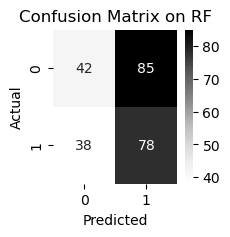

In [56]:
con_matrix = pd.crosstab(pd.Series(pd.DataFrame(y_test).values.flatten(), name='Actual'),
                         pd.Series(pd.DataFrame(predictions).values.flatten(), name='Predicted'))
plt.figure(figsize=(2, 2))
plt.title("Confusion Matrix on RF")
sns.heatmap(con_matrix, cmap="Greys", annot=True, fmt='g')
plt.show()

# Bert

In [27]:
def free_memory():

    # Specify the directory path to be deleted
    directory_path = '/my_model'

    # Regex pattern to match the files you want to delete
    pattern = r"checkpoint-*"  # Replace with your regex pattern
    pt_save_directory = "./pt_save_pretrained"

    # Load the tokenizer
    roberta_tokenizer = AutoTokenizer.from_pretrained(pt_save_directory)

    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(pt_save_directory)

    # Get a list of file paths that match the regex pattern
    file_paths = glob.glob(os.path.join(directory_path, "*"))
    file_paths_to_delete = [file_path for file_path in file_paths if re.search(pattern, file_path)]

    # Delete the files
    for file_path in file_paths_to_delete:
        shutil.rmtree(file_path)
    #     os.remove(file_path)

In [28]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should pr

In [29]:
training_args = TrainingArguments(
    output_dir="my_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps = 100,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    push_to_hub=False,
)

In [30]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    predictions = np.argmax(logits, axis=1)
    macro_f1 = f1_score(labels, predictions, average='macro')
    return {'macro_f1': macro_f1}

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

In [32]:
trainer.args.device

device(type='cuda', index=0)

In [ ]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()
free_memory()

In [34]:
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)
test_set = tokenized_datasets["test"]
test_set = test_set.to_pandas().drop(['attention_mask', 'input_ids'], axis =1)
test_set["label"] = preds
test_set['label'] = test_set['label'].map({0: 'SUBJ', 1: 'OBJ'})
test_set.to_csv('final_result.tsv', sep = '\t', index = None, header=True)


In [35]:
pt_save_directory = "./pt_save_pretrained"
roberta_tokenizer.save_pretrained(pt_save_directory)
model.save_pretrained(pt_save_directory)

In [ ]:
import copy
os.environ["WANDB_DISABLED"] = "true"

param_grid = {
    'learning_rate': [1.5e-5, 2e-5],
    'per_device_train_batch_size': [8, 16],
    'per_device_eval_batch_size': [8, 16],
    'weight_decay': [0.001],
    'num_train_epochs': [5, 10],
}
model_grid = ParameterGrid(param_grid)

data = []
head = ['learning_rate', 'per_device_train_batch_size', 'weight_decay', 'num_train_epochs', 'score in validation set']
bes_trainer =''
best_args = ''

max_score = {'eval_macro_f1': 0.0}

i = 0

for param in model_grid:
    i += 1
    print(i)
    
    torch.cuda.empty_cache()
    
    current_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
    
    training_args = TrainingArguments(
    output_dir="my_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps = 10,
    **param,
    )

    trainer = Trainer(
    model = current_model,
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    compute_metrics = compute_metrics,
    )

    trainer.train()
    score = trainer.evaluate(tokenized_datasets["validation"])
    if score['eval_macro_f1'] > max_score['eval_macro_f1']:
        max_score = score
        best_args = copy.deepcopy(training_args)
        
    list_entry = [param['learning_rate'], param['per_device_train_batch_size'], param['weight_decay'], param['num_train_epochs'], score]
    data.insert(0, list_entry)
    print(list_entry)
    
    del training_args
    del trainer
    free_memory()



In [ ]:
for de in data:
  de[4] = de[4]['eval_macro_f1']


In [ ]:
print(tabulate(data, headers=head, tablefmt="pipe"))
max_accuracy = max(entry[4] for entry in data)
best_model = next(item for item in data if item[4] == max_accuracy)
print("The highest Accuracy %f is the model model with learning_rate = %s, per_device_train_batch_size = %s, num_train_epochs = %f" %
      (best_model[4], best_model[0], best_model[1], best_model[3]))

In [ ]:
def model_results(training_args, name):
    
    model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


    trainer = Trainer(
    model=model,
    args=best_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    )
    
    trainer.train()
    predictions = trainer.predict(tokenized_datasets["test"])
    preds = np.argmax(predictions.predictions, axis=-1)
    
    test_set = tokenized_datasets["test"]
    test_set = test_set.to_pandas().drop(['attention_mask', 'input_ids'], axis =1)
    test_set["label"] = preds
    test_set['label'] = test_set['label'].map({0: 'SUBJ', 1: 'OBJ'})
    
    test_set.to_csv(name + '_result.tsv', sep = '\t', index = None, header=True)

    
    del predictions
    del preds
    del test_set
    del model
    del trainer
    free_memory()

In [ ]:
model_results(best_args, 'sencond')

In [ ]:
second_best_args = TrainingArguments(
    output_dir="my_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps = 10,
    learning_rate = 1.5e-05,
    per_device_train_batch_size = 8,
    weight_decay = 0.001,
    num_train_epochs = 10,
    )
model_results(second_best_args, 'third')

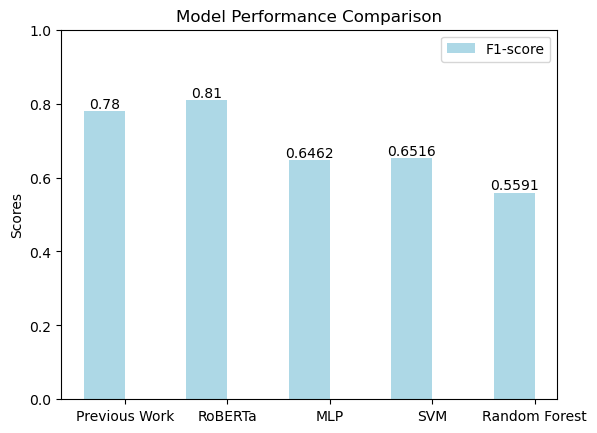

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Results for Previous Work
prev_f1_score = 0.78
prev_accuracy = 0.779

# Results for RoBERTa
roberta_macro_f1 = 0.81
roberta_accuracy = 0.8148148148148148

# Results for MLP
mlp_f1_score = 0.64624
mlp_accuracy = 0.652308

# Results for SVM
svm_f1_score = 0.65156
svm_accuracy = 0.656347

# Results for Random Forest
rf_f1_score = 0.55914
rf_accuracy = 0.658307

# Create a histogram
labels = ['Previous Work', 'RoBERTa', 'MLP', 'SVM', 'Random Forest']
f1_scores = [prev_f1_score, roberta_macro_f1, mlp_f1_score, svm_f1_score, rf_f1_score]
accuracies = [prev_accuracy, roberta_accuracy, mlp_accuracy, svm_accuracy, rf_accuracy]

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()

f1_bars = ax.bar(x - width/2, f1_scores, width, label='F1-score', color='lightblue')

ax.set_ylabel('Scores')
ax.set_ylim([0, 1])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right')

# Attach values above bars
for bar in f1_bars :
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.title('Model Performance Comparison')
plt.show()
